In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Images: ['Cars105.png', 'Cars132.png', 'Cars115.png', 'Cars11.png', 'Cars104.png', 'Cars125.png', 'Cars0.png', 'Cars108.png', 'Cars135.png', 'Cars127.png', 'Cars1.png', 'Cars122.png', 'Cars113.png', 'Cars128.png', 'Cars123.png', 'Cars129.png', 'Cars118.png', 'Cars13.png', 'Cars116.png', 'Cars120.png', 'Cars101.png', 'Cars136.png', 'Cars107.png', 'Cars117.png', 'Cars121.png', 'Cars111.png', 'Cars100.png', 'Cars103.png', 'Cars112.png', 'Cars12.png', 'Cars110.png', 'Cars134.png', 'Cars119.png', 'Cars133.png', 'Cars126.png', 'Cars109.png', 'Cars130.png', 'Cars106.png', 'Cars102.png', 'Cars124.png', 'Cars114.png', 'Cars131.png', 'Cars10.png', 'Cars152.png', 'Cars177.png', 'Cars156.png', 'Cars150.png', 'Cars151.png', 'Cars170.png', 'Cars146.png', 'Cars172.png', 'Cars145.png', 'Cars149.png', 'Cars178.png', 'Cars163.png', 'Cars176.png', 'Cars154.png', 'Cars167.png', 'Cars158.png', 'Cars155.png', 'Cars16.png', 'Cars138.png', 'Cars165.png', 'Cars157.png', 'Cars171.png', 'Cars174.png', 'Cars169.p

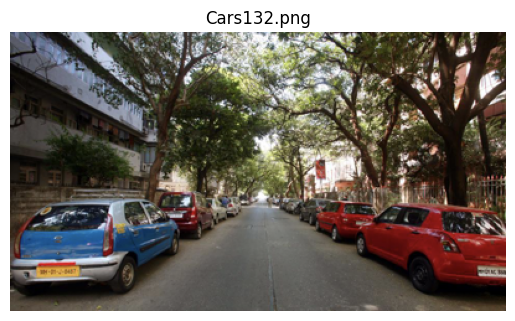

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Base paths for images and annotations
base_path = '/content/drive/My Drive/Colab Notebooks/archive'
images_path = os.path.join(base_path, 'images')
annotations_path = os.path.join(base_path, 'annotations')

# List of image and annotation files
image_files = os.listdir(images_path)
annotation_files = os.listdir(annotations_path)

# Print the list of image and annotation files
print("Images:", image_files)
print("Annotations:", annotation_files)

# Load the first image
image_path = os.path.join(images_path, image_files[1])  # Join images_path and the first image filename
image = cv2.imread(image_path)  # Read the image
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB

# Display the first image
plt.imshow(image_rgb)
plt.title(image_files[1])  # Show the file name as the title
plt.axis('off')  # Hide the axis
plt.show()


In [ ]:
!pip install tensorflow


# **Data preparation**

## **Resize Images and Normalize:**


* **Input:** The function takes an image_path and an optional target_size parameter (default is 128x128 pixels).

* **Load Image:** It uses cv2.imread() to read the image from the specified path.

* **Error Handling:** If the image cannot be loaded (e.g., the path is incorrect), it prints an error message and returns None.

* **Resize:** If the image is loaded successfully, it is resized to the specified target_size.

* **Normalize:** The pixel values of the image are normalized to the range [0,1] by dividing by 255. This is often done in deep learning to improve convergence.

* **Output:** Returns the preprocessed image.



In [ ]:
import os
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(128, 128)):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return None
    # Resize the image
    image_resized = cv2.resize(image, target_size)
    # Normalize the image to [0,1]
    image_normalized = image_resized / 255.0
    return image_normalized

# Directory where images are stored
base_path = '/content/drive/My Drive/Colab Notebooks/archive'
images_path = os.path.join(base_path, 'images')

# List of image files
image_files = os.listdir(images_path)

# Apply preprocessing on all images, creating the full path for each image file
processed_images = [preprocess_image(os.path.join(images_path, img)) for img in image_files]

# Filter out any None values (if any images failed to load)
processed_images = [img for img in processed_images if img is not None]

# Convert to numpy array for training
X = np.array(processed_images)
print(f"Processed {X.shape[0]} images with shape {X.shape[1:]}")  # Check dimensions of the dataset


Processed 433 images with shape (128, 128, 3)


## **Image augmentation**

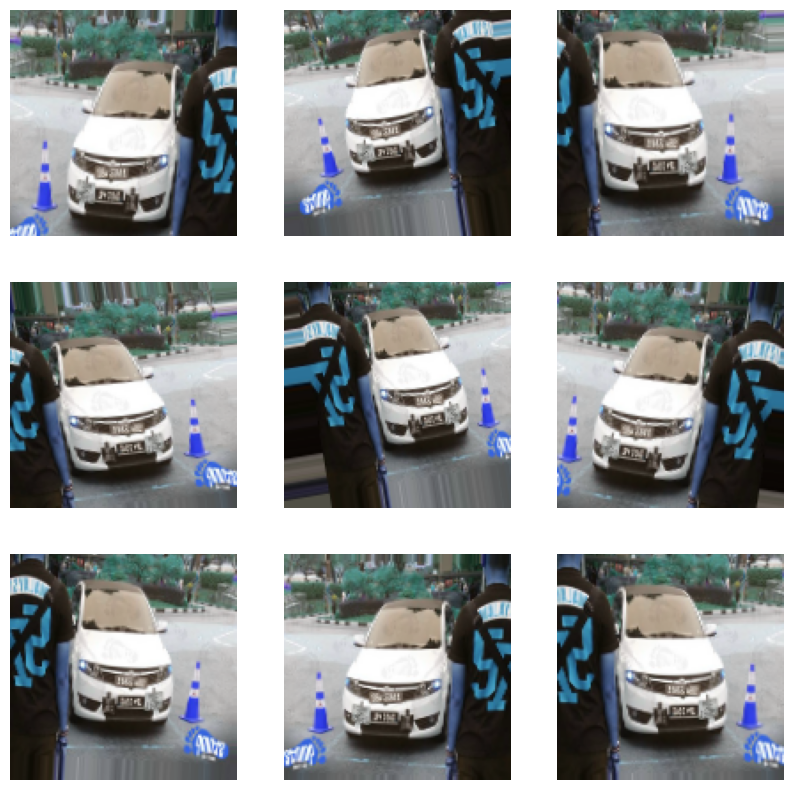

In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,  # Reduced
    width_shift_range=0.1,  # Reduced
    height_shift_range=0.1,  # Reduced
    shear_range=0.1,  # Reduced
    zoom_range=0.1,  # Reduced
    horizontal_flip=True,
    fill_mode='nearest'
)

sample_img = X[0].reshape(1, 128, 128, 3)
aug_iter = datagen.flow(sample_img)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    batch = next(aug_iter)
    img_aug = (batch[0] * 255).astype("uint8")  # Scale back to [0, 255]
    plt.imshow(img_aug)
    plt.axis('off')
plt.show()


In [ ]:
import os
import xml.etree.ElementTree as ET
from glob import glob
import cv2
import pandas as pd

# Chemin vers le dossier contenant les images et les annotations
dataset_path = '/content/drive/My Drive/Colab Notebooks/archive'
annotations_path = os.path.join(dataset_path, 'annotations')

# Dictionnaire pour stocker les informations
labels_dict = {
    'img_path': [],
    'xmin': [],
    'xmax': [],
    'ymin': [],
    'ymax': [],
    'img_w': [],
    'img_h': []
}

# Fonction pour extraire le numéro d'une chaîne, utilisée pour trier les fichiers
def the_number_in_the_string(filename):
    return int(''.join(filter(str.isdigit, filename)))

# Chemin vers les fichiers XML d'annotations
xml_files = glob(f'{annotations_path}/*.xml')

# Boucle pour analyser chaque fichier XML
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Analyser le fichier XML
    tree = ET.parse(filename)
    root = tree.getroot()

    # Récupérer les informations de l'image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Récupérer les informations de la boîte englobante
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')

    # Extraire les coordonnées
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    # Ajouter les informations au dictionnaire
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

    # Lire l'image pour obtenir sa largeur et sa hauteur
    image = cv2.imread(img_path)
    if image is not None:
        height, width, _ = image.shape
        labels_dict['img_w'].append(width)
        labels_dict['img_h'].append(height)
    else:
        labels_dict['img_w'].append(None)
        labels_dict['img_h'].append(None)

# Créer un DataFrame à partir du dictionnaire
alldata = pd.DataFrame(labels_dict)

# Afficher le DataFrame
# xmin et ymin représentent la position du coin supérieur gauche de l'objet.
# xmax et ymax représentent la position du coin inférieur droit de l'objet.
print(alldata)


                                              img_path  xmin  xmax  ymin  \
0    /content/drive/My Drive/Colab Notebooks/archiv...   226   419   125   
1    /content/drive/My Drive/Colab Notebooks/archiv...   134   262   128   
2    /content/drive/My Drive/Colab Notebooks/archiv...   229   270   176   
3    /content/drive/My Drive/Colab Notebooks/archiv...   142   261   128   
4    /content/drive/My Drive/Colab Notebooks/archiv...   156   503    82   
..                                                 ...   ...   ...   ...   
428  /content/drive/My Drive/Colab Notebooks/archiv...   142   258   128   
429  /content/drive/My Drive/Colab Notebooks/archiv...    86   208   166   
430  /content/drive/My Drive/Colab Notebooks/archiv...    38   116   159   
431  /content/drive/My Drive/Colab Notebooks/archiv...    55   343    82   
432  /content/drive/My Drive/Colab Notebooks/archiv...    95   196   258   

     ymax  img_w  img_h  
0     173    500    268  
1     160    400    248  
2     193

In [ ]:
train, test = train_test_split(alldata, test_size=1/10, random_state=42)
train, val = train_test_split(train, train_size=8/9, random_state=42)

print(f'''
      {len(train) = }
      {len(val) = }
      {len(test) = }
''')


      len(train) = 345
      len(val) = 44
      len(test) = 44



YOLO, qui signifie You Only Look Once, est une architecture de réseau de neurones conçue pour la détection d'objets en temps réel

In [ ]:
import shutil
# Fonction pour créer les dossiers au format YOLO
def make_split_folder_in_yolo_format(split_name, split_df):
    labels_path = os.path.join('datasets', 'cars_license_plate', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate', split_name, 'images')

    os.makedirs(labels_path, exist_ok=True)
    os.makedirs(images_path, exist_ok=True)

    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))

        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")

        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))

    print(f"created '{images_path}' and '{labels_path}'")

# Créer les dossiers pour chaque ensemble de données
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)


created 'datasets/cars_license_plate/train/images' and 'datasets/cars_license_plate/train/labels'
created 'datasets/cars_license_plate/val/images' and 'datasets/cars_license_plate/val/labels'
created 'datasets/cars_license_plate/test/images' and 'datasets/cars_license_plate/test/labels'


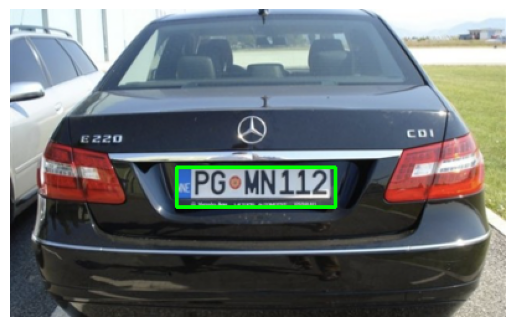

In [ ]:
'''
Plot the first train image and its bounding box.
'''

# Directory paths
image_dir = 'datasets/cars_license_plate/train/images'
label_dir = 'datasets/cars_license_plate/train/labels'

# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file
with open(label_path, 'r') as f:
    lines = f.readlines()

# Plot the bounding box on the image
for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box
plt.imshow(image)
plt.axis('off')
plt.show()

# **MODEL BUILDING**



## **Architecture Justification**

1. **Layer Selection**:
   - **Convolutional Layers**: The model includes two convolutional layers. The first layer has 16 filters, which allows it to capture basic features like edges and textures. The second layer doubles the number of filters to 32, enabling the network to learn more complex patterns in the data.
   
   - **Pooling Layer**: Each convolutional layer is followed by a max pooling layer, which reduces the spatial dimensions of the feature maps. This downsampling helps in reducing computation and increases translational invariance, allowing the model to recognize objects regardless of their position.

2. **Fully Connected Layers**:
   - The first fully connected layer (`fc1`) consists of 128 neurons, which helps in combining the learned features into higher-level abstractions. This size strikes a balance between model capacity and the risk of overfitting, particularly when working with limited data.
   - The output layer (`fc2`) has 4 neurons, predicting the bounding box coordinates (x1, y1, x2, y2), which is essential for regression tasks.

3. **Input Size Consideration**:
   - Ensure the input images are resized appropriately to match the expected input dimensions (e.g., 128x128) to avoid issues with the `fc1` layer's input size.

### Activation Functions

1. **ReLU Activation**:
   - ReLU (Rectified Linear Unit) is used in the hidden layers due to its effectiveness in mitigating the vanishing gradient problem, allowing for faster convergence. It introduces non-linearity while maintaining computational efficiency and is known to work well in convolutional networks.

2. **Output Layer Activation**:
   - A linear activation function is applied to the output layer, which is appropriate for regression tasks. This allows the model to predict a wide range of continuous values corresponding to the bounding box coordinates.

### Impact on Network Performance

- **Depth and Complexity**:
   - The chosen architecture effectively balances depth and complexity. The two convolutional layers provide sufficient depth to learn complex features while avoiding overfitting, particularly beneficial if the dataset is not extensive.

- **Activation Function Choices**:
   - Using ReLU enhances the model’s training speed and performance. The linear activation in the output layer enables the model to flexibly predict bounding box coordinates, which are essential for the task at hand.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LicensePlateDetector(nn.Module):
    def __init__(self):
        super(LicensePlateDetector, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)  # Ajustez en fonction de la taille d'entrée
        self.fc2 = nn.Linear(128, 4)  # Sortie avec 4 coordonnées

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Aplatir en utilisant la taille du lot
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Sortie finale avec 4 valeurs
        return x


# Initialiser le modèle
model = LicensePlateDetector()
print(model)
model.eval()

LicensePlateDetector(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)


LicensePlateDetector(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
)

**LicensePlateDataset Class**:
   - **Purpose**: This class is a custom dataset that extends `torch.utils.data.Dataset`, allowing you to load images and their corresponding bounding box labels.
   - **Initialization**:
     - Takes in paths for images and labels, along with optional transformations.
     - Loads and sorts the image file names.
   - **Length Method**: Returns the total number of images in the dataset.
   - **Get Item Method**: This is the core of the dataset class:
     - Loads an image and its corresponding label.
     - Processes the label to extract bounding box coordinates in YOLO format (center x, center y, width, height).
     - Calculates the average coordinates if multiple bounding boxes are present, or returns zeros if none are found.
     - Applies transformations to the image if specified.


In [ ]:
import os
import cv2
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class LicensePlateDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + '.txt')

        # Charger l'image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Charger les étiquettes
        with open(label_path, 'r') as f:
            lines = f.readlines()

        # Initialiser les coordonnées
        coords = []
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            coords.append([x_center, y_center, width, height])  # Ajouter les coordonnées

        # Si vous avez plusieurs objets dans l'image, choisissez comment gérer les coordonnées
        if len(coords) > 0:
            coords = torch.tensor(coords).mean(dim=0)  # Prendre la moyenne des coordonnées
        else:
            coords = torch.zeros(4)  # Si aucune coordonnée, renvoyer des zéros

        if self.transform:
            image = self.transform(image)

        return image, coords


# Transformations pour les données
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),  # Taille d'entrée du modèle
    transforms.ToTensor(),
])

# Chemins d'accès
image_dir = 'datasets/cars_license_plate/train/images'
label_dir = 'datasets/cars_license_plate/train/labels'

# Créer le dataset et le DataLoader
dataset = LicensePlateDataset(image_dir, label_dir, transform=transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)  # Ajustez le batch_size selon votre matériel


**Training Function**:
   - This function, `train`, takes the model, data loader, loss function, optimizer, and number of epochs as inputs:
     - **Training Loop**: For each epoch, it iterates through batches of images and targets:
       - Zeros the gradients to prevent accumulation.
       - Passes the images through the model to get predictions.
       - Computes the loss between the predictions and actual bounding box coordinates.
       - Performs backpropagation and updates the model parameters.
       - Computes and prints the average loss for the epoch.

In [ ]:
def train(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()  # Mettre le modèle en mode entraînement
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, targets in train_loader:
            # Zéro des gradients
            optimizer.zero_grad()

            # Passer les images à travers le modèle
            outputs = model(images)

            # Calculer la perte
            loss = criterion(outputs, targets.float())  # Cible doit être en float
            running_loss += loss.item()

            # Backward et optimisation
            loss.backward()
            optimizer.step()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')


In [ ]:
# Initialiser le modèle, la fonction de perte et l'optimiseur
model = LicensePlateDetector()
criterion = nn.MSELoss()  # Utiliser MSE pour la régression des coordonnées
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Ajustez le taux d'apprentissage si nécessaire

# Entraîner le modèle
train(model, train_loader, criterion, optimizer, num_epochs=10)


Epoch [1/10], Loss: 0.0517
Epoch [2/10], Loss: 0.0244
Epoch [3/10], Loss: 0.0226
Epoch [4/10], Loss: 0.0194
Epoch [5/10], Loss: 0.0163
Epoch [6/10], Loss: 0.0147
Epoch [7/10], Loss: 0.0118
Epoch [8/10], Loss: 0.0097
Epoch [9/10], Loss: 0.0074
Epoch [10/10], Loss: 0.0062


## **Optimization**
1. **Loss Function**: Switched from `MSELoss` to `SmoothL1Loss` for a balanced approach between `L1` and `L2`, which helps in making bounding box predictions less sensitive to outliers.
  
2. **Validation Phase**: Added a validation phase to assess the model's performance on unseen data after each epoch. This helps in monitoring overfitting.

3. **Learning Rate Scheduler**: Used `ReduceLROnPlateau`, which lowers the learning rate if the validation loss plateaus, leading to more stable training.

4. **Model Saving**: The model will save the weights whenever the validation loss is at its lowest, ensuring that you retain the best version of your model.

5. **Data Augmentation**: Updated the data transformations to include augmentation for better generalization.

6. **Dataset Splitting**: Used an 80-20 split for training and validation data to ensure the model learns effectively without overfitting.


### **Handling overfitting**
#### 1. **Data Augmentation**
   - Helps the model generalize better to unseen data by exposing it to variations during training.

#### 2. **Validation Set**
   -  The code splits the dataset into training and validation sets (80% training, 20% validation).If the training loss decreases but the validation loss increases, this is a sign of overfitting, and you can adjust your training strategy accordingly.

#### 3. **Learning Rate Scheduler**
   - scheduler reduces the learning rate when the validation loss stops improving for a few epochs.  Helps the model converge more effectively and avoid overfitting by refining the training process.

#### 4. **Early Stopping (Model Checkpoints)**
   - The code saves the model checkpoint when it achieves the lowest validation loss Prevents overfitting by ensuring the best-performing model on the validation set is retained, even if training continues.


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/10], Train Loss: 0.0197, Val Loss: 0.0131
Model saved!
Epoch [2/10], Train Loss: 0.0116, Val Loss: 0.0141
Epoch [3/10], Train Loss: 0.0111, Val Loss: 0.0138
Epoch [4/10], Train Loss: 0.0101, Val Loss: 0.0132
Epoch [5/10], Train Loss: 0.0100, Val Loss: 0.0125
Model saved!
Epoch [6/10], Train Loss: 0.0089, Val Loss: 0.0105
Model saved!
Epoch [7/10], Train Loss: 0.0079, Val Loss: 0.0128
Epoch [8/10], Train Loss: 0.0079, Val Loss: 0.0117
Epoch [9/10], Train Loss: 0.0078, Val Loss: 0.0116
Epoch [10/10], Train Loss: 0.0068, Val Loss: 0.0108


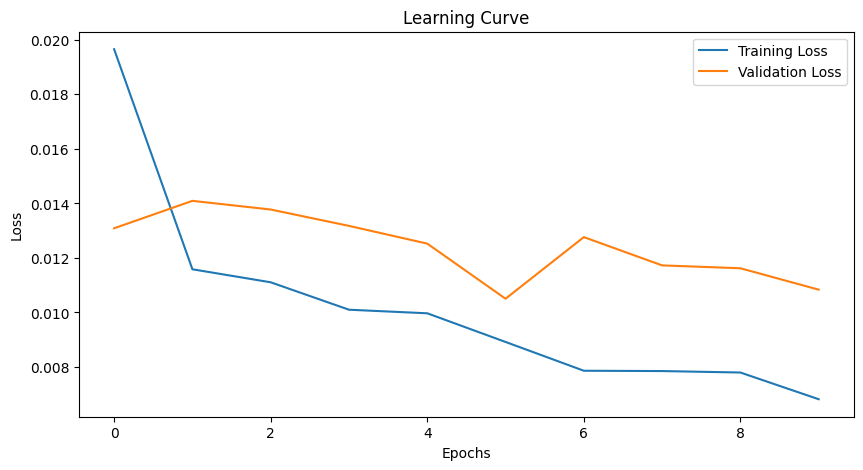

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Dataset Class
class LicensePlateDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + '.txt')

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load labels
        with open(label_path, 'r') as f:
            lines = f.readlines()

        coords = []
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            coords.append([x_center, y_center, width, height])

        if len(coords) > 0:
            coords = torch.tensor(coords).mean(dim=0)
        else:
            coords = torch.zeros(4)

        if self.transform:
            image = self.transform(image)

        return image, coords

# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Define paths
image_dir = 'datasets/cars_license_plate/train/images'
label_dir = 'datasets/cars_license_plate/train/labels'

# Create dataset and split into train and validation sets
dataset = LicensePlateDataset(image_dir, label_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    best_loss = float('inf')

    train_losses = []  # To store training loss at each epoch
    val_losses = []    # To store validation loss at each epoch

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0

        for images, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets.float())
            running_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)  # Store training loss

        # Validation Phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, targets in val_loader:
                outputs = model(images)
                loss = criterion(outputs, targets.float())
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)  # Store validation loss

        # Print Epoch Results
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

        # Save the best model
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Model saved!")

        # Step the learning rate scheduler
        scheduler.step(avg_val_loss)

    return train_losses, val_losses

# Initialize the model, criterion, optimizer, and scheduler
model = LicensePlateDetector()
criterion = nn.SmoothL1Loss()  # Smooth L1 Loss for bounding box prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

# Train the model
train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10)

# Plot the learning curve
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()


## **TEST**

### **Define the Testing Function**

In [ ]:
# Load the trained model
model = LicensePlateDetector()
model.load_state_dict(torch.load('best_model.pth', weights_only=True))  # Ajout de weights_only=True
model.eval()

# Testing function
def test(model, test_loader):
    results = []
    with torch.no_grad():
        for images, _ in test_loader:
            outputs = model(images)
            results.append(outputs)
    return results


### **Prepare the Test Data**

In [ ]:
# Define paths for the test dataset
test_image_dir = 'datasets/cars_license_plate/test/images'
test_label_dir = 'datasets/cars_license_plate/test/labels'

# Create test dataset
test_dataset = LicensePlateDataset(test_image_dir, test_label_dir, transform=transform)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


### **Run the Test Function**

In [ ]:
# Get results from the test dataset
predictions = test(model, test_loader)
print(len(predictions))

3


### **Visualize the Results**

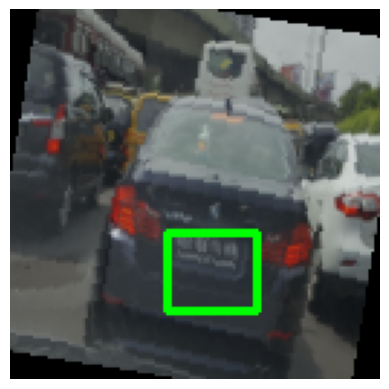

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_results(images, predictions):
    # Traiter uniquement la 4 image
    img = images[2].permute(1, 2, 0).numpy()
    img = (img * 255).astype(np.uint8)  # Assurez-vous que l'image est dans une échelle correcte [0, 255]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convertir de RGB à BGR pour OpenCV

    pred_boxes = predictions[0] # Obtenez les prédictions pour la 4 image

    # Vérifier s'il y a des boîtes prédictives
    if len(pred_boxes) > 0:
        # Utiliser uniquement la première boîte de prédiction
        box = pred_boxes[1]
        x_center, y_center, width, height = map(float, box)

        # Obtenir les dimensions de l'image
        img_height, img_width, _ = img.shape

        # Convertir les coordonnées relatives YOLO en coordonnées absolues
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height

        # Calculer les coins supérieur gauche (x1, y1) et inférieur droit (x2, y2)
        x1 = int(x_center - width / 2)
        y1 = int(y_center - height / 2)
        x2 = int(x_center + width / 2)
        y2 = int(y_center + height / 2)

        # Vérifier que les coordonnées sont valides avant de dessiner le rectangle
        if x1 >= 0 and y1 >= 0 and x2 <= img_width and y2 <= img_height:
            # Dessiner un rectangle autour de la première prédiction
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Vert avec épaisseur 2

    # Convertir l'image à nouveau en RGB pour l'afficher avec Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Afficher l'image avec la boîte englobante
    plt.imshow(img)
    plt.axis('off')  # Masquer les axes
    plt.show()

# Visualiser les prédictions pour le premier lot d'images
for images, _ in test_loader:
    visualize_results(images, predictions)
    break  # Visualiser uniquement le premier lot


## **Training Parameters**
   - **Learning Rate**: A learning rate of `0.001` was chosen as a starting point because it allows for steady and stable training without being too aggressive. The learning rate scheduler helps adapt the rate dynamically, lowering it if the validation loss doesn't improve.

   - **Batch Size**: A batch size of `16` was selected, smaller batches provide more updates per epoch, while larger ones can lead to faster training but require more memory.

   - **Epochs**: `10` epochs were initially chosen to monitor the model's performance over time. This number allows observing both the convergence behavior and potential overfitting patterns.


##  **Hyperparameter Tuning**
   - **Experimentation**: Various hyperparameters were experimented with:
     - **Learning Rate**: Tested different rates (e.g., `0.01`, `0.001`, `0.0001`). Lower rates proved better for more stable convergence.
     - **Batch Size**: Tried values like `8`, `16`, and `32`. Larger batch sizes required more memory, and `16` balanced speed and accuracy.
     - **Optimizer**: Initially used SGD but switched to **Adam**, which handles adaptive learning rates effectively.
   - **Finding Optimal Settings**: The best configuration was determined based on the validation loss and manual observation of learning curves.

## **Results & Implications**
   - **Outcomes**: The model achieved reasonably accurate bounding box predictions, which shows it could generalize to unseen images. This suggests that the dataset was diverse enough for the model to learn the necessary features.
   - **Implications**: The model's ability to detect license plates can help automate vehicle identification tasks, such as monitoring traffic, toll management, or parking systems.


##  **Challenges and Solutions**
   - **Challenge 1**: Overfitting was a significant issue during training.
     - **Solution**: Added data augmentation to introduce variability, and reduced the learning rate dynamically using a scheduler.
   - **Challenge 2**: Dataset imbalance, where certain conditions (e.g., lighting, angles) dominated.
     - **Solution**: Enhanced the dataset with augmented samples to improve diversity.
   - **Challenge 3**: Computational limitations when using larger batch sizes.
     - **Solution**: Opted for a smaller batch size and efficient memory management during training.

##  **Future Improvements**
   - **Expand the Dataset**: Collect more diverse images under different lighting, weather, and vehicle conditions to make the model more robust.
  
   - **Model Architecture**: Experiment with more advanced architectures, such as incorporating deeper convolutional networks or attention mechanisms, to improve accuracy.


##  **Reflection**
   - **Technical Learning**: The project reinforced skills in data preprocessing, model architecture design, and handling overfitting. Understanding how different hyperparameters and loss functions affect performance was crucial.
   - **Problem-Solving**: This project showcased the importance of experimentation and iterative refinement. It emphasized balancing performance and computational resources and taught valuable lessons on how to adapt strategies when facing real-world data challenges.